In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
path = "/content/MyDrive/MyDrive/imgObjects100"

In [ ]:
!pip install opencv-python numpy tqdm matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
couch = "/content/MyDrive/MyDrive/imgObjects100/couch"
oven = "/content/MyDrive/MyDrive/imgObjects100/oven"
tv = "/content/MyDrive/MyDrive/imgObjects100/tv"
washer = "/content/MyDrive/MyDrive/imgObjects100/washer"
microwave = "/content/MyDrive/MyDrive/imgObjects100/microwave"
bath = "/content/MyDrive/MyDrive/imgObjects100/bath"
smartstove = "/content/MyDrive/MyDrive/imgObjects100/smartstove"
elstove = "/content/MyDrive/MyDrive/imgObjects100/elstove"
gastove = "/content/MyDrive/MyDrive/imgObjects100/gastove"
boiler = "/content/MyDrive/MyDrive/imgObjects100/boiler"
ref = "/content/MyDrive/MyDrive/imgObjects100/ref"
bed = "/content/MyDrive/MyDrive/imgObjects100/bed"
cabin = "/content/MyDrive/MyDrive/imgObjects100/cabin"

data_dir = path

batch_size = 20
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 1300 files belonging to 13 classes.
Using 1040 files for training.
Found 1300 files belonging to 13 classes.
Using 260 files for validation.
['bath', 'bed', 'boiler', 'cabin', 'couch', 'elstove', 'gastove', 'microwave', 'oven', 'ref', 'smartstove', 'tv', 'washer']


In [ ]:
#Искусственное увеличение данных, используя слои из tf.keras.layers.experimental.preprocessing, путем их дополнения с помощью случайных преобразований. 
#Из одного изображения получаем 9 (отзеркаливаний)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

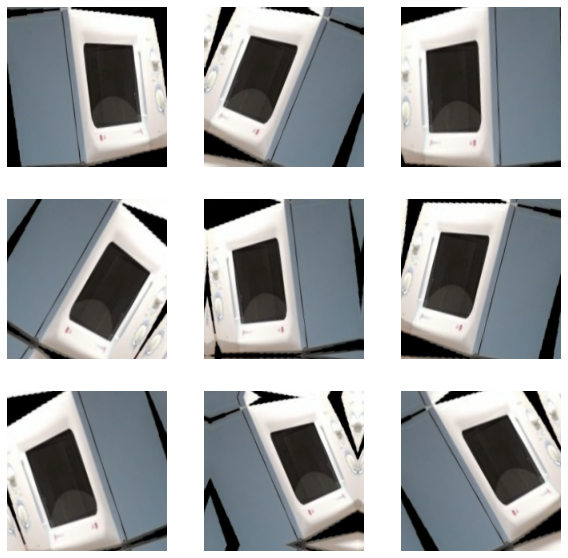

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 200, 200, 3)
(20,)


In [ ]:
#Буферизованная предварительная выборка, чтобы передавать данные с диска без блокировки ввода-вывода.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Стандартизирование данных
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8667991


In [ ]:
#Модель, не факт что слои настроенны правильно.
num_classes = 13

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)       

In [ ]:
#Обучение на 15 эпохах
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
52/52 [==============================] - 80s 2s/step - loss: 2.3077 - accuracy: 0.2298 - val_loss: 1.9149 - val_accuracy: 0.3346
Epoch 2/15
52/52 [==============================] - 51s 973ms/step - loss: 1.6602 - accuracy: 0.4538 - val_loss: 1.3063 - val_accuracy: 0.5615
Epoch 3/15
52/52 [==============================] - 50s 964ms/step - loss: 1.3772 - accuracy: 0.5423 - val_loss: 1.1314 - val_accuracy: 0.6115
Epoch 4/15
52/52 [==============================] - 50s 967ms/step - loss: 1.2309 - accuracy: 0.5971 - val_loss: 1.0403 - val_accuracy: 0.6385
Epoch 5/15
52/52 [==============================] - 50s 960ms/step - loss: 1.1524 - accuracy: 0.6240 - val_loss: 1.0558 - val_accuracy: 0.6192
Epoch 6/15
52/52 [==============================] - 50s 956ms/step - loss: 1.0043 - accuracy: 0.6788 - val_loss: 0.9487 - val_accuracy: 0.6577
Epoch 7/15
52/52 [==============================] - 50s 954ms/step - loss: 0.9183 - accuracy: 0.7077 - val_loss: 0.8894 - val_accuracy: 0.7154
Ep

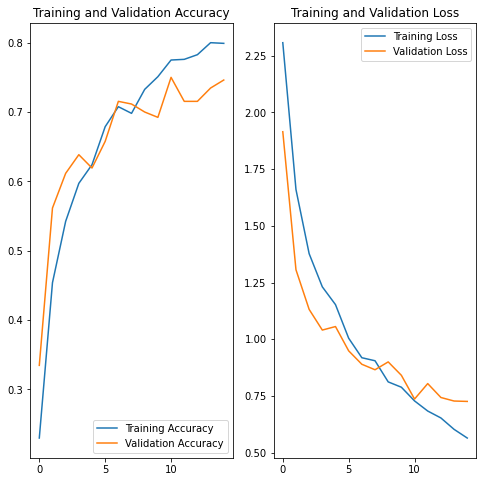

In [ ]:
#Графическое представление точности обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

_______________________________________________________________________
Это изображение похоже на couch с вероятностью в 98.20 %


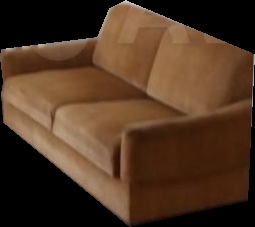

_______________________________________________________________________
Это изображение похоже на smartstove с вероятностью в 98.97 %


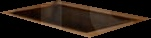

_______________________________________________________________________
Это изображение похоже на tv с вероятностью в 94.13 %


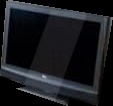

_______________________________________________________________________
Это изображение похоже на smartstove с вероятностью в 90.24 %


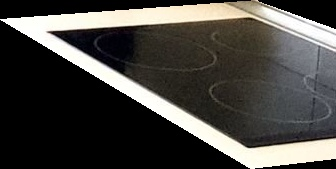

_______________________________________________________________________
Это изображение похоже на washer с вероятностью в 99.46 %


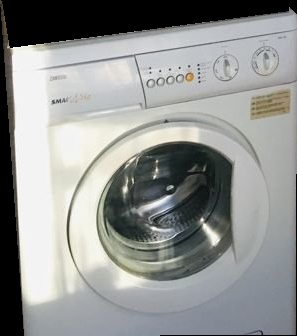

_______________________________________________________________________
Это изображение похоже на ref с вероятностью в 54.57 %


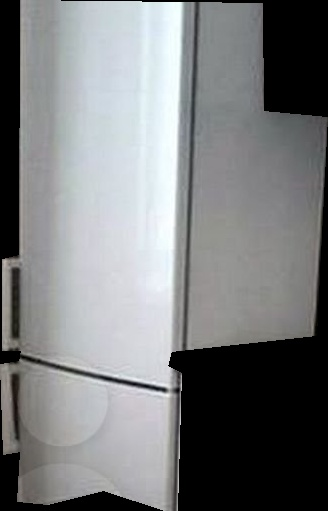

_______________________________________________________________________
Это изображение похоже на cabin с вероятностью в 99.23 %


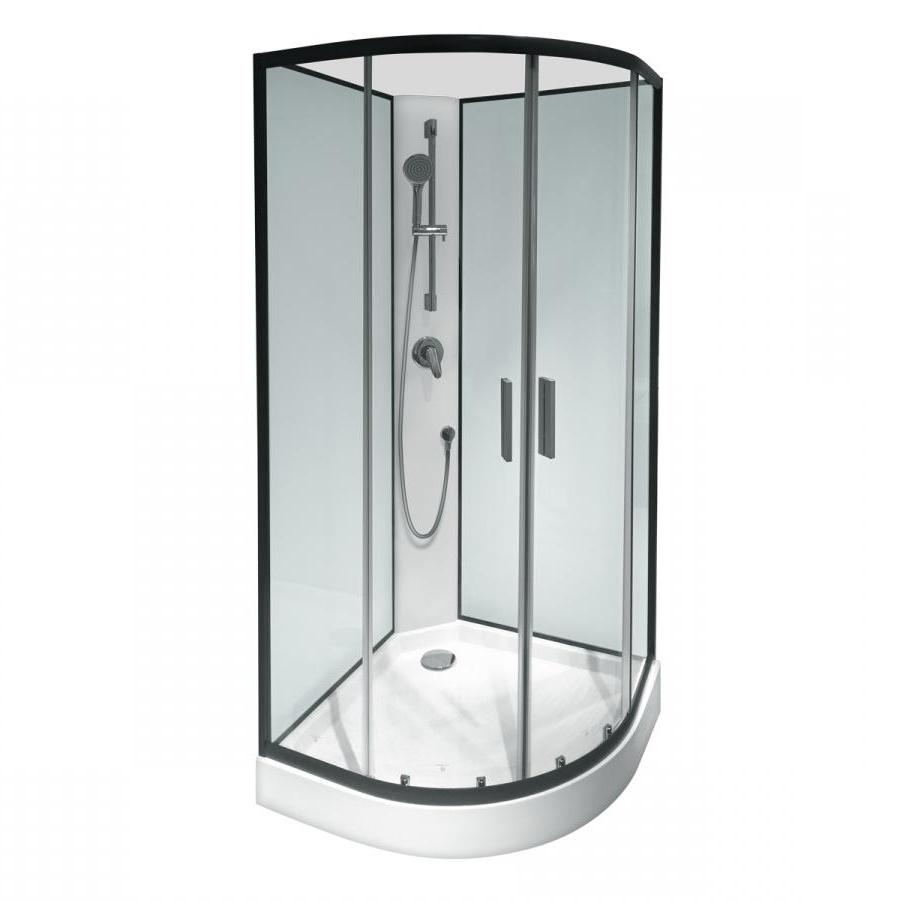

In [ ]:
#Проверка роботоспособности (указать ссылку на директорию с изображениями)

#пути к директориям c фото для проверки (заменить pathdate)
#/content/MyDrive/MyDrive/forvalid/couch
#/content/MyDrive/MyDrive/forvalid/bath
#/content/MyDrive/MyDrive/forvalid/bed
#/content/MyDrive/MyDrive/forvalid/elstove
#/content/MyDrive/MyDrive/forvalid/smartstove
#/content/MyDrive/MyDrive/forvalid/washer
#/content/MyDrive/MyDrive/forvalid/ref
#/content/MyDrive/MyDrive/forvalid/tv
#/content/MyDrive/MyDrive/forvalid/oven
#/content/MyDrive/MyDrive/forvalid/microwave

pathdate = '/content/MyDrive/MyDrive/forval'

listPhoto = os.listdir(pathdate)
for name in listPhoto:
  imgcheck = pathdate + name
  img = keras.preprocessing.image.load_img(
      imgcheck, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) 

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

 #показать все проценты
  #count = 0
  #for i in score:
  #      print("Это изображение похоже на {} с вероятностью в {:.2f} %"
  #    .format(class_names[count], 100 * np.max(i)))
  #     count = count + 1

  print("_______________________________________________________________________")
  print(
      "Это изображение похоже на {} с вероятностью в {:.2f} %"
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

  import cv2
  frame=cv2.imread(os.path.join(pathdate + name))
  from google.colab.patches import cv2_imshow
  cv2_imshow(frame)